<a href="https://colab.research.google.com/github/Priyagane/Talking_data_Bagging_and_Boosting/blob/main/talking_data_Bagging_and_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Loading

In [93]:

%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import zscore

In [94]:
df = pd.read_csv('/content/talking_data.csv')
df.head(10)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0
5,93663,3,1,17,115,2017-11-09 01:22:13,NaN,0
6,17059,1,1,17,135,2017-11-09 01:17:58,NaN,0
7,121505,9,1,25,442,2017-11-07 10:01:53,NaN,0
8,192967,2,2,22,364,2017-11-08 09:35:17,NaN,0
9,143636,3,1,19,135,2017-11-08 12:35:26,NaN,0


Data Cleaning

In [95]:
df.shape #shape of the dataset

(100000, 8)

In [96]:
df.info() #dtypes of all the columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  int64 
 1   app              100000 non-null  int64 
 2   device           100000 non-null  int64 
 3   os               100000 non-null  int64 
 4   channel          100000 non-null  int64 
 5   click_time       100000 non-null  object
 6   attributed_time  227 non-null     object
 7   is_attributed    100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


**1. Explore the dataset for anomalies and missing values and take corrective actions if necessary.**

In [97]:
#checking the null values
df.isnull().values.any()

True

In [98]:
#Identifing missing Values
miss_val = df.isna().sum()
miss_val

ip                     0
app                    0
device                 0
os                     0
channel                0
click_time             0
attributed_time    99773
is_attributed          0
dtype: int64

In [99]:
#delecting the attributed_time column.
df.drop('attributed_time',axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ip             100000 non-null  int64 
 1   app            100000 non-null  int64 
 2   device         100000 non-null  int64 
 3   os             100000 non-null  int64 
 4   channel        100000 non-null  int64 
 5   click_time     100000 non-null  object
 6   is_attributed  100000 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 5.3+ MB



**2. Which column has maximum number of unique values present among all the available columns**

In [100]:
#maximum number of unique values present among all the available columns
df_col = list(df.columns)
for i in df_col:

  val = df[[i]].value_counts().count()
  
  print(i,':',val)

ip : 34857
app : 161
device : 100
os : 130
channel : 161
click_time : 80350
is_attributed : 2


In [101]:
df.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [102]:
#correlation
corr = df.corr()
corr

,ip,app,device,os,channel,is_attributed
ip,1.000000,0.010400,-0.001499,-0.000470,0.007563,0.054955
app,0.010400,1.000000,0.248376,0.247160,-0.028238,0.064426
device,-0.001499,0.248376,1.000000,0.924456,-0.035398,-0.000695
os,-0.000470,0.247160,0.924456,1.000000,-0.033175,0.006183
channel,0.007563,-0.028238,-0.035398,-0.033175,1.000000,-0.023336
is_attributed,0.054955,0.064426,-0.000695,0.006183,-0.023336,1.000000


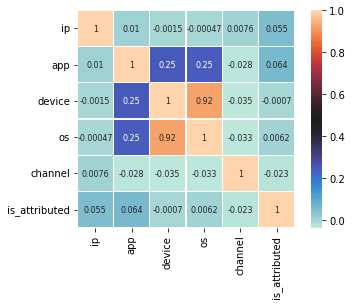

In [103]:
sns.heatmap(corr,cmap='icefire', linewidth=0.2,annot=True,annot_kws={'size':8},square=True)


**3. Use an appropriate technique to get rid of all the apps that are very rare (say which comprise of less                than 20% clicks) and plot the rest..** 

In [104]:
#removed the rows which has less than 20% clicks.
app_click= df.groupby('app').size().reset_index(name='count')
app_click = app_click[app_click['count']>app_click['count'].quantile(.8)]
app_click

,app,count
0,1,3135
1,2,11737
2,3,18279
4,5,188
5,6,1303
6,7,981
7,8,2004
8,9,8992
9,10,388
10,11,1927


In [107]:
df['click_time'].head()


0    2017-11-07 09:30:38
1    2017-11-07 13:40:27
2    2017-11-07 18:05:24
3    2017-11-07 04:58:08
4    2017-11-09 09:00:09
Name: click_time, dtype: object


**4. By using Pandas derive new features such as - 'day_of_week' , 'day_of_year' , 'month' , and 'hour' as                  float/int datatypes using the 'click_time' column . Add the newly derived columns in original dataset.**

In [108]:
#adding new features 'day_of_week' , 'day_of_year' , 'month' , and 'hour from clic_time feature
df['click_time']=pd.to_datetime(df['click_time'])
df['hour']=df['click_time'].dt.hour
df['month']=df['click_time'].dt.month
df['day_of_week']=df['click_time'].dt.day_of_week
df['day_of_year']=df['click_time'].dt.day_of_year

In [109]:
df.head()

,ip,app,device,os,channel,click_time,is_attributed,hour,month,day_of_week,day_of_year
0,87540,12,1,13,497,2017-11-07 09:30:38,0,9,11,1,311
1,105560,25,1,17,259,2017-11-07 13:40:27,0,13,11,1,311
2,101424,12,1,19,212,2017-11-07 18:05:24,0,18,11,1,311
3,94584,13,1,13,477,2017-11-07 04:58:08,0,4,11,1,311
4,68413,12,1,1,178,2017-11-09 09:00:09,0,9,11,3,313


In [116]:
#df=df.drop(['click_time'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   ip             100000 non-null  int64
 1   app            100000 non-null  int64
 2   device         100000 non-null  int64
 3   os             100000 non-null  int64
 4   channel        100000 non-null  int64
 5   is_attributed  100000 non-null  int64
 6   hour           100000 non-null  int64
 7   month          100000 non-null  int64
 8   day_of_week    100000 non-null  int64
 9   day_of_year    100000 non-null  int64
dtypes: int64(10)
memory usage: 7.6 MB


Divide the data into training and testing subsets into 80:20 ratio(Train_data = 80% , Testing_data = 20%) and
     check the average download rates('is_attributed') for train and test data, scores should be comparable.**

In [117]:
X = df.drop(['is_attributed'],axis=1)
X.head()

,ip,app,device,os,channel,hour,month,day_of_week,day_of_year
0,87540,12,1,13,497,9,11,1,311
1,105560,25,1,17,259,13,11,1,311
2,101424,12,1,19,212,18,11,1,311
3,94584,13,1,13,477,4,11,1,311
4,68413,12,1,1,178,9,11,3,313


In [119]:
Y=df['is_attributed']
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: is_attributed, dtype: int64

In [123]:
Y.value_counts()

0    99773
1      227
Name: is_attributed, dtype: int64

In [121]:
# Splitting Data set into train and validation

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.20,random_state = 1)

In [185]:
#checking the shape of the traning set
print('Dimension of train_X :',X_train.shape)
print('Dimension of train_Y :',Y_train.shape)
print('Dimension of test_X :',X_test.shape)
print('Dimension of test_Y :',Y_test.shape)

Dimension of train_X : (159636, 9)
Dimension of train_Y : (159636,)
Dimension of test_X : (20000, 9)
Dimension of test_Y : (20000,)


In [130]:
#using SMOTE to balance the dataset
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12)
x_train_sm, y_train_sm = sm.fit_resample(X_train,Y_train)
Y_train.value_counts()

0    79818
1    79818
Name: is_attributed, dtype: int64


**6. Apply XGBoostClassifier with default parameters on training data and make first 10 prediction for Test data.          NOTE: Use y_pred = model.predict_proba(X_test) since we need probabilities to compute AUC.** 

In [188]:
import xgboost as xgb
from sklearn import metrics
#from xgboost import XGBClassifer
xgcl = xgb.XGBClassifier()
xgcl = xgcl.fit(x_train_sm, y_train_sm)
test_pred = xgcl.predict(X_test)
xgcl_score=xgcl.score(X_test , Y_test)


**7. On evaluating the predictions made by the model what is the AUC/ROC score with default hyperparameters.**

In [189]:
print("The xgboost model accuracy is {}".format(xgcl_score))
print("The confusion matrix of xgboost Model is")
print(metrics.confusion_matrix(Y_test,test_pred))
print("AUC",metrics.roc_auc_score(Y_test,test_pred))
print(metrics.classification_report(Y_test,test_pred))

The xgboost model accuracy is 0.96765
The confusion matrix of xgboost Model is
[[19314   641]
 [    6    39]]
AUC 0.9172721957738245
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     19955
           1       0.06      0.87      0.11        45

    accuracy                           0.97     20000
   macro avg       0.53      0.92      0.55     20000
weighted avg       1.00      0.97      0.98     20000



In [190]:
#first 10 prediction for Test data
test_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

First 10 prediction for Test data:
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])





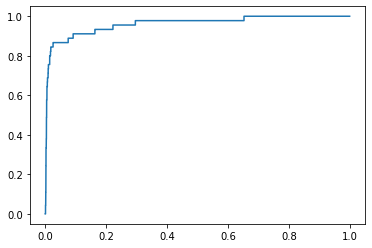

In [153]:
#ROC curves produce AUC values :0.91
import matplotlib.pyplot as plt 
test_pred = xgcl.predict_proba(X_test)
a,r,_ = metrics.roc_curve(Y_test,test_pred[:,1])
plt.plot(a,r)

AUC/ROC score :0.9172721957738245

Compute feature importance score and name the top 5 features/columns .**

In [191]:
#using RFECV to compute the feature importance score
from sklearn.feature_selection import RFECV
model2 = RFECV(estimator=xgcl,step=1,verbose=1,cv=5)
model2.fit(X_train,Y_train)


Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator wi

RFECV(cv=5, estimator=XGBClassifier(), verbose=1)

In [193]:
#feature importance score
xgcl.feature_importances_

array([0.12575355, 0.37537873, 0.24143732, 0.04452645, 0.08645011,
       0.03010856, 0.        , 0.0963453 , 0.        ], dtype=float32)

In [166]:
#top 5 features/columns compute by RFECV
X_train.columns[model2.support_]

Index(['ip', 'app', 'device', 'os', 'channel', 'hour', 'day_of_week'], dtype='object')

After computing feature importance score, the top 5 features/columns are:
'ip', 'app', 'device', 'os', 'channel'

**9. Apply BaggingClassifier with base_estimator LogisticRegression and compute AUC/ROC score.

In [194]:
#BaggingClassifier with base_estimator LogisticRegression 
from numpy.random.mtrand import logistic
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
bgc = BaggingClassifier(base_estimator=LogisticRegression())
bgcl = bgc.fit(x_train_sm,y_train_sm)
test_pred = bgcl.predict(X_test)
bgcl_score=bgcl.score(X_test, Y_test)


In [196]:
#computing AUC/ROC score
print("The Bagging classifier model accuracy is {}".format(bgcl_score))
print("The confusion matrix of Bagging classifier model is")
print(metrics.confusion_matrix(Y_test,test_pred))
print(metrics.classification_report(Y_test,test_pred))
print("AUC",metrics.roc_auc_score(Y_test,test_pred))

The Bagging classifier model accuracy is 0.83135
The confusion matrix of Bagging classifier model is
[[16592  3363]
 [   10    35]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     19955
           1       0.01      0.78      0.02        45

    accuracy                           0.83     20000
   macro avg       0.50      0.80      0.46     20000
weighted avg       1.00      0.83      0.91     20000

AUC 0.8046242935493749


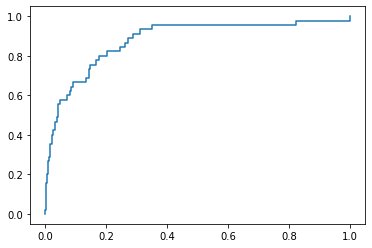

In [184]:
#ROC curves produce AUC values :0.80
test_pred_bg = bgc.predict_proba(X_test)
a,r,_ = metrics.roc_curve(Y_test,test_pred_bg[:,1])
plt.plot(a,r)

**10.  On the basis of AUC/ROC score which one will you choose from BaggingClassifier and XGBoostClassifier and              why?What does AUC/ROC score signifies?

I choose XGBoostClassifier, because      AUC/ROC score :0.9172, recall score 1: 0.87 and accuracy: 0.97
:


**11.  What is the accuracy for BaggingClassifier and XGBoostClassifier?()

Accuracy for BaggingClassifier:0.83
Accuracy for XGBoostClassifier:0.97